In [1]:
import easyocr
import re
import cv2
from tqdm.notebook import tqdm
from datetime import datetime
from tools.frame_detector import FrameDetector, Frame
from matplotlib import pyplot as plt
import matplotlib.patches as patches


In [2]:
file_name = "test/samples/sample_episode.mp4"
vidcap = cv2.VideoCapture(file_name)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS)
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
h, w, _ = image.shape


In [4]:
frames = {}

pbar = tqdm(total=frame_count)
count = 0
while(success):
    if count % (2 * fps) == 0:  # every 2 seconds
        success, image = vidcap.read()

        # get frame timestamp
        timestamp = vidcap.get(cv2.CAP_PROP_POS_MSEC) / 1000
        timestamp = datetime.fromtimestamp(timestamp).strftime('%M:%S')
        
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            frames[timestamp] = image[h//2:h, w//2:w]

    else:
        ret = vidcap.grab()
    count += 1
    # pbar.update(1)
# pbar.close()

  0%|          | 0/77932 [00:00<?, ?it/s]

In [ ]:
detector = FrameDetector(frames)
detector.detect()

In [32]:
found = detector.found
best_frames = []
one_cnt, two_cnt = 0, 0
counts = [one_cnt, two_cnt]
for frame in found:
    curr = 0 if frame.text[0] == '1' else 1
    # print(f"{curr=}")
    if counts[curr] == 0 or (counts[curr] > 0 and frame.min_time_diff(best_frames) > 60):
        # print(f"{frame.min_time_diff(best_frames)=}")
        best_frames.append(frame)
        counts[curr] += 1    
    # print(f"{counts=}, {counts[curr]=}, {one_cnt=}, {two_cnt=}\n")
print(len(found), len(best_frames))
for i in found:
    print(i.text, i.stamp)


9 5
2.00 48:59
2.00 49:01
2.00 49:03
2.00 45:47
1.00 25:35
1.00 34:47
1.00 34:49
1:00 50:29
1:00 46:47


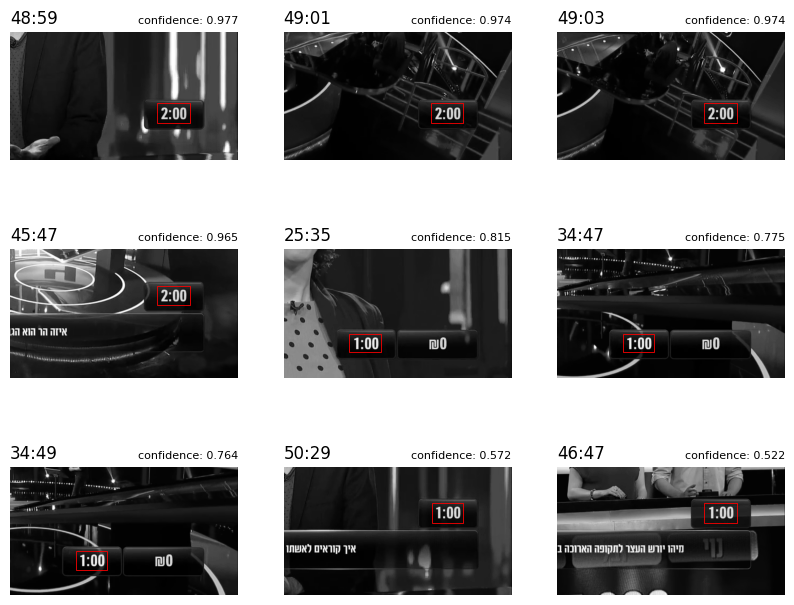

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(10,8))
axs = axs.flatten()
for i, frame in enumerate(found):
    x1, y1 = frame.rect[0]
    x2, y2 = frame.rect[2]
    w, h = x2 - x1, y2 - y1
    axs[i].axis('off')   
    axs[i].set_title(f"{frame.stamp}", loc="left")
    axs[i].set_title("confidence: {:.3}".format(frame.confidence), fontsize=8, loc="right")
    rect = patches.Rectangle((x1 - 5, y1 - 5), w + 5, h + 5, linewidth=0.6, edgecolor='r', facecolor='none')
    axs[i].add_patch(rect)
    axs[i].imshow(frames[frame.stamp], cmap="gray")

In [ ]:
vidcap.release()